In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
# import sklearn
import sklearn.metrics
import sklearn.datasets
import sklearn.linear_model
import matplotlib
# from copy import deepcopy

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [2]:
# For progress bar
import time
from IPython.display import display
from ipywidgets import IntProgress, VBox
from ipywidgets import HTML as Label

## Generating a dataset

Let's start by generating a dataset we can play with.

In [3]:
# Generate a dataset and plot it
np.random.seed(1)

num_classes = 3
base_clr = plt.cm.brg
def fade(color):
    return color * 0.4 + 0.6
def darken(color):
    return color * 0.6
if type(base_clr) is matplotlib.colors.LinearSegmentedColormap:
    map_clr = {}
    for clr in ['red', 'green', 'blue']:
        map_clr[clr] = [(c[0], *map(fade, c[1:]))
                        for c in base_clr._segmentdata[clr]]
    map_clr = matplotlib.colors.LinearSegmentedColormap('colormap', map_clr)
    dot_clr = {}
    for clr in ['red', 'green', 'blue']:
        dot_clr[clr] = [(c[0], *map(darken, c[1:]))
                        for c in base_clr._segmentdata[clr]]
    dot_clr = matplotlib.colors.LinearSegmentedColormap('colormap', dot_clr)
elif type(base_clr) is matplotlib.colors.ListedColormap:
    map_clr = [[c[0], *map(fade, c[1:])]
               for c in base_clr.colors]
    map_clr = matplotlib.colors.ListedColormap(map_clr)
    dot_clr = [[c[0], *map(darken, c[1:])]
               for c in base_clr.colors]
    dot_clr = matplotlib.colors.ListedColormap(dot_clr)
else:
    raise(Exception)

def true_class(x, y):
    return (np.round(x).astype(int) +
            np.round(y).astype(int)) % num_classes

m = num_classes / 2 + 0.2
h = 0.01
# Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(-m, m, h),
                     np.arange(-m, m, h))

X0 = (np.random.uniform(size=(2000, 2)) - 0.5) * num_classes

# Add noise and determine classification
z = np.random.normal(size=X0.shape) * 0
y = X0 + z
# Limit noisy y to eliminate changes in classes at outside edges of data
# Comment out to allow those transitions
y = np.minimum(num_classes/2, np.maximum(-num_classes/2, y))
y = true_class(y[:, 0], y[:, 1])

In [4]:
# Add data for input to neural net
X = np.hstack([X0, X0%2, np.prod(X0, axis=1, keepdims=True)])
# And the same for our background
xy = np.vstack([xx.ravel(), yy.ravel()]).T
xy = np.hstack([xy, xy%2, np.prod(xy, axis=1, keepdims=True)])

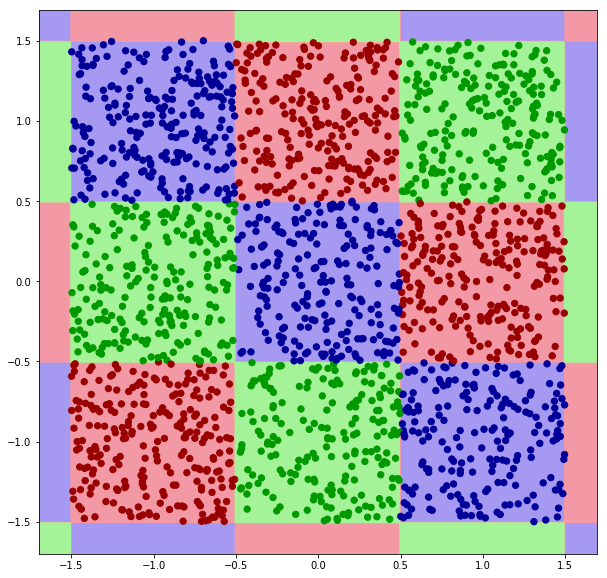

In [5]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Predict the function value for the whole gid
    Z = pred_func(xy).reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=map_clr)
    plt.scatter(X0[:,0], X0[:,1], s=40, c=y, cmap=dot_clr)
    
plot_decision_boundary(lambda x: true_class(x[:, 0], x[:, 1]))

## Training a Neural Network

### Implementation

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [6]:
num_examples = X.shape[0] # training set size
nn_input_dim = X.shape[1] # input layer dimensionality
nn_output_dim = num_classes # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [7]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [8]:
# Helper function to predict an output
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [9]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    start = time.time()
    lim = num_passes
    label = Label()
    progress = IntProgress(min=0, max=lim-1, value=0)
    box = VBox(children=[label, progress])
    display(box)
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if i % 100 == 0:
            etime = time.time() - start
            rtime = etime/(i+1)*(lim-i-1)
            label.value = f'{i+1}/{lim} complete in {etime:.2f} seconds. Estimated {rtime:.2f} seconds remaining.'
            progress.value=i
            
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    label.value = f'{lim} complete in {etime:.2f} seconds.'
    progress.bar_style = 'success'

    return model

### A network with a hidden layer of size ?

Let's see what happens if we train a network with a hidden layer size of 3.


VBox(children=(HTML(value=''), IntProgress(value=0, max=19999)))

Loss after iteration 0: 7.470438
Loss after iteration 1000: 4.884233
Loss after iteration 2000: 1.203500
Loss after iteration 3000: 0.279596
Loss after iteration 4000: 0.303089
Loss after iteration 5000: 0.328271
Loss after iteration 6000: 0.289623
Loss after iteration 7000: 1.540036
Loss after iteration 8000: 2.688929
Loss after iteration 9000: 0.225266
Loss after iteration 10000: 0.213862
Loss after iteration 11000: 0.232470
Loss after iteration 12000: 0.203326
Loss after iteration 13000: 0.192509
Loss after iteration 14000: 0.388124
Loss after iteration 15000: 0.220026
Loss after iteration 16000: 0.228888
Loss after iteration 17000: 0.168093
Loss after iteration 18000: 0.139859
Loss after iteration 19000: 0.816932


array([[643,   7,   5],
       [ 12, 699,   0],
       [ 21,  17, 596]])

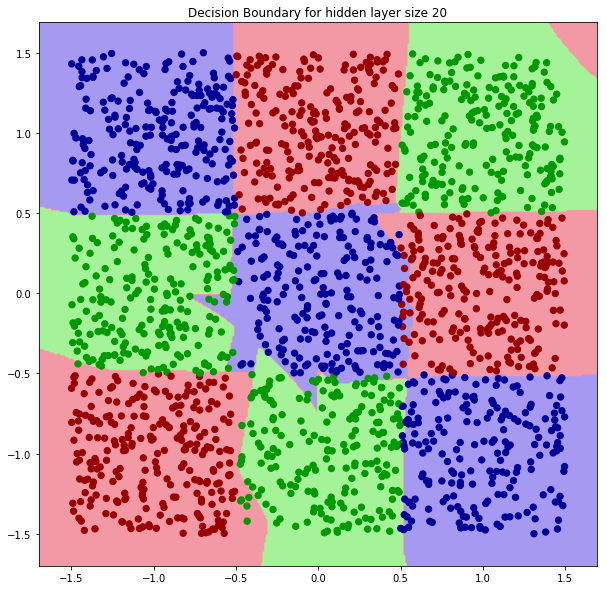

In [10]:
# Build a model with a 3-dimensional hidden layer
model = build_model(20, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 20")

sklearn.metrics.confusion_matrix(y, predict(model, X))

# Varying the hidden layer size

VBox(children=(HTML(value=''), IntProgress(value=0, max=19999)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=19999)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=19999)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=19999)))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


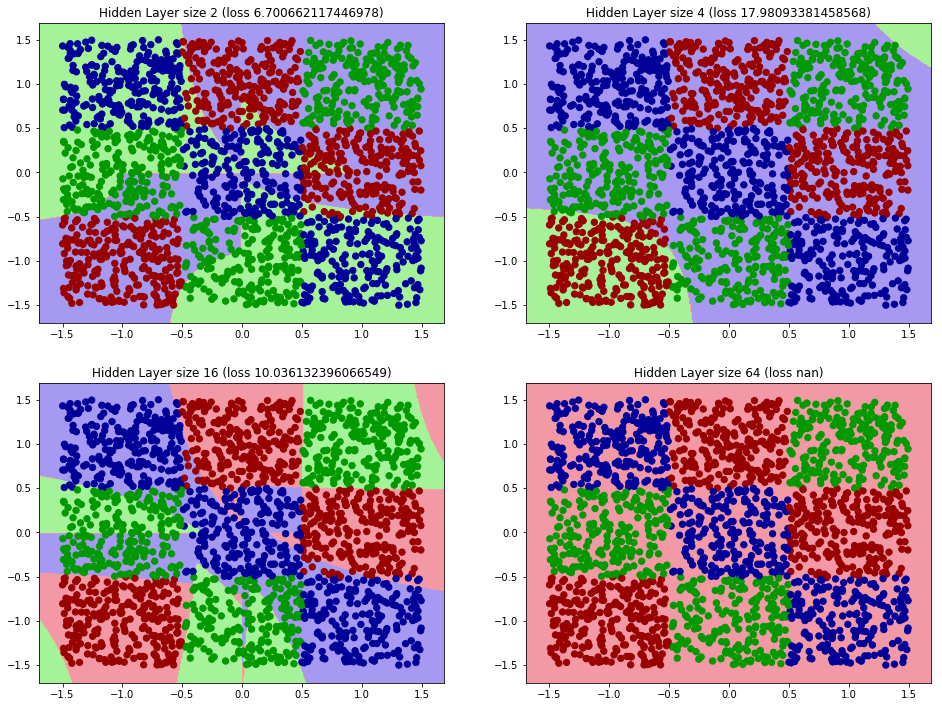

In [11]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [2, 4, 16, 64]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    model = build_model(nn_hdim)
    plt.title('Hidden Layer size {} (loss {})'.format(nn_hdim, calculate_loss(model)))
    plot_decision_boundary(lambda x: predict(model, x))